<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preparación-de-Data" data-toc-modified-id="Preparación-de-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preparación de Data</a></span></li><li><span><a href="#Modelos" data-toc-modified-id="Modelos-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Modelos</a></span></li><li><span><a href="#Testeo" data-toc-modified-id="Testeo-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Testeo</a></span></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Estilo de plot
# from jupyterthemes import jtplot
# jtplot.style(gridlines='--', figsize=(20, 8), ticks=True, spines=False, fscale=1.35)
plt.rcParams['figure.figsize'] = (20, 8)
plt.rcParams['lines.linewidth'] = 2
from cycler import cycler
current_cycle_list = plt.rcParams['axes.prop_cycle'].by_key()['color']
current_cycle_list[1] = 'mediumseagreen'
# current_cycle_list[0], current_cycle_list[1] = current_cycle_list[1], current_cycle_list[0]
plt.rcParams['axes.prop_cycle'] = cycler('color', current_cycle_list)

# Preparación de Data

In [2]:
# Leer csvs
maiz  = pd.read_csv('corn-prices-historical-chart-data.csv'   , index_col=0,  parse_dates=True, names=['fecha', 'maiz'],  header=0)
soja  = pd.read_csv('soybean-prices-historical-chart-data.csv', index_col=0,  parse_dates=True, names=['fecha', 'soja'],  header=0)
trigo = pd.read_csv('wheat-prices-historical-chart-data.csv  ', index_col=0,  parse_dates=True, names=['fecha', 'trigo'], header=0)

# Juntarlos
df = pd.concat([maiz, soja, trigo], axis=1).dropna()

cols = df.columns

df.tail(3)

,maiz,soja,trigo
fecha,,,
2022-06-28,7.2360,16.2085,9.2715
2022-06-29,7.0650,16.1260,9.2420
2022-06-30,6.8525,15.9205,9.2710


In [3]:
# Agregar logs de las variables
for c in cols:
    df[c + 'log'] = df[c].apply(np.log)
df.tail()

,maiz,soja,trigo,maizlog,sojalog,trigolog
fecha,,,,,,
2022-06-24,7.5025,16.1075,9.2375,2.015236,2.779285,2.223271
2022-06-27,7.2765,16.1030,9.0670,1.984650,2.779006,2.204641
2022-06-28,7.2360,16.2085,9.2715,1.979069,2.785536,2.226945
2022-06-29,7.0650,16.1260,9.2420,1.955153,2.780433,2.223758
2022-06-30,6.8525,15.9205,9.2710,1.924614,2.767608,2.226891


In [4]:
# Pasar de data diaria a semanal, y filtar del 2000 para adelante
df = df.resample('w').first()
df = df[df.index >= '2000']
print(df.shape)
df

(1175, 6)


,maiz,soja,trigo,maizlog,sojalog,trigolog
fecha,,,,,,
2000-01-02,2.0400,4.6020,2.4700,0.712950,1.526491,0.904218
2000-01-09,2.0075,4.6450,2.4750,0.696890,1.535791,0.906240
2000-01-16,2.0850,4.7350,2.5350,0.734769,1.554982,0.930194
2000-01-23,2.2000,5.0225,2.6450,0.788457,1.613928,0.972671
2000-01-30,2.2725,5.1200,2.6600,0.820881,1.633154,0.978326
...,...,...,...,...,...,...
2022-06-05,7.5350,16.8325,10.8750,2.019559,2.823312,2.386467
2022-06-12,7.4250,16.9925,10.9300,2.004853,2.832772,2.391511
2022-06-19,7.6925,17.0750,10.7100,2.040246,2.837615,2.371178


# Modelos

In [5]:
def predictRandomWalk(train_data, n_steps, index=None):
    a = [train_data[-1]]
    for i in range(n_steps-1):
        a.append(a[-1] + train_data[-8:].diff().mean() * np.sign((np.random.random() - 0.5)) * 1)
    return pd.Series(a, index=index)

# a = []
# for i in range(500):
#     a.append(predictRandomWalk(train, steps, test.index))
# mydf = pd.concat(a, axis=1)
# preds = mydf.quantile([0.5, 0.1, 0.9], axis=1).T

# from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
# arima = ARIMA(train, order=(10, 2, 1)).fit()
# preds = arima.get_forecast(steps).summary_frame().drop('mean_se', axis=1)
# arima.summary()

In [6]:
# Preparación de train data y test data
grano = 'maiz'
y = df[grano+'log']
train = y[y.index < '2022-02-15']
test  = y[y.index >= '2022-02-15']

In [7]:
# Importar modelos
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from skforecast.ForecasterAutoreg import ForecasterAutoreg # Modelo que hace la iteración

# Para escalar variables de 0 a 1 (la red neuronal lo necesita)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()


lags = 8 # lags a usar
steps = len(test) # ctdad de períodos a forecastear
rs = 5 # random state fijo para testear los modelos más fácilmente

forecaster =  ForecasterAutoreg(regressor = MLPRegressor(solver='lbfgs', random_state=rs),
                               lags = lags)

In [8]:
# Escalar variables y entrenar modelo
forecaster.fit(pd.Series(scaler.fit_transform(train.to_frame())[:, 0]))
# Predecir y reescalar variables
preds = forecaster.predict_interval(steps, n_boot=500, random_state=rs)
preds = pd.DataFrame(scaler.inverse_transform(preds), columns=['pred', '0.05', '0.95'])
preds.index = test.index
preds.tail()

,pred,0.05,0.95
fecha,,,
2022-06-05,1.850300,1.679796,2.005033
2022-06-12,1.850475,1.688294,1.997175
2022-06-19,1.850655,1.691443,2.005678
2022-06-26,1.850807,1.684958,2.014485
2022-07-03,1.850957,1.663367,2.013806


In [9]:
# Si es diff, integrar y sumar constante
# preds[0] = preds[0].cumsum() + train.cumsum()[-1]
# preds[1] = preds[1] + preds[0]
# preds[2] = preds[2] + preds[0]
# test = test.cumsum() + train.cumsum()[-1]

(2610.0, 2766.0)

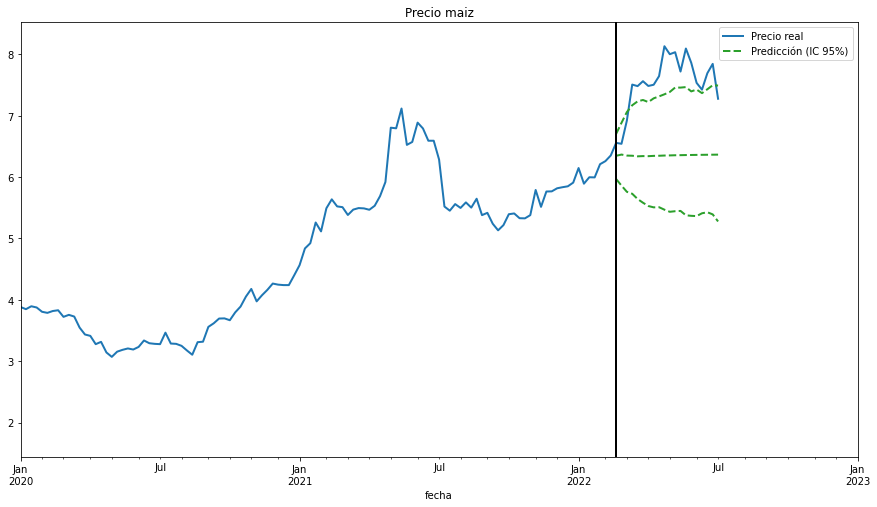

In [10]:
# Gráfico de predicciones
fig, ax = plt.subplots(figsize=(15, 8))
y.apply(np.exp).plot(ax=ax)
preds.apply(np.exp).plot(c='C2', ls='--', ax=ax)
plt.axvline('2022-02-20', c='k', ls='-')
# plt.gca().vlines('2022-01-01', ymin=1000, ymax=2000, color='k')
plt.legend(['Precio real', 'Predicción (IC 95%)'])
plt.title(f'Precio {grano}'.capitalize())
plt.xlim('2020', '2023')

# Testeo

In [11]:
# Backtesting

from tqdm.notebook import tqdm # barra de progreso
from statsmodels.tsa.arima.model import ARIMA

# Uso una porción de training data que sea más estacionaria
train_back = train[train.index < '2019-11-01']

init_train_size = int(len(train_back)*0.8) 

# Entrenamiento inicial con 80% de la training data
# Predecir siguientes n períodos/steps, almacenar predicciones, agrandar training data en n (steps) y repetir proceso
a = []
for i in tqdm(range((len(train_back) - init_train_size)//steps-1)):
    
    # Habría que hacerlo función para poder elegir el modelo desde el argumento
    
    # Modelo sklearn
    forecaster.fit(train_back.iloc[:init_train_size+i*steps])
    back_preds = forecaster.predict(steps)
    
    ## ARIMA
    # arima = ARIMA(train_back.iloc[:init_train_size+i*steps], order=(6, 1, 1)).fit()
    # back_preds = arima.forecast(steps)
    
    ## RW
    # back_preds = predictRandomWalk(train_back.iloc[:train_back+i*steps],
    #                           steps,
    #                           train_back.iloc[init_train_size+i*steps:init_train_size+i*steps+steps].index)
    
    # a.append(train_back.iloc[:init_train_size+i*steps].cumsum()[-1] + back_preds.cumsum()) # Si es diff, integrar y sumar constante
    a.append(back_preds)
backtesting_series = pd.concat(a, axis=1)

  0%|          | 0/9 [00:00<?, ?it/s]

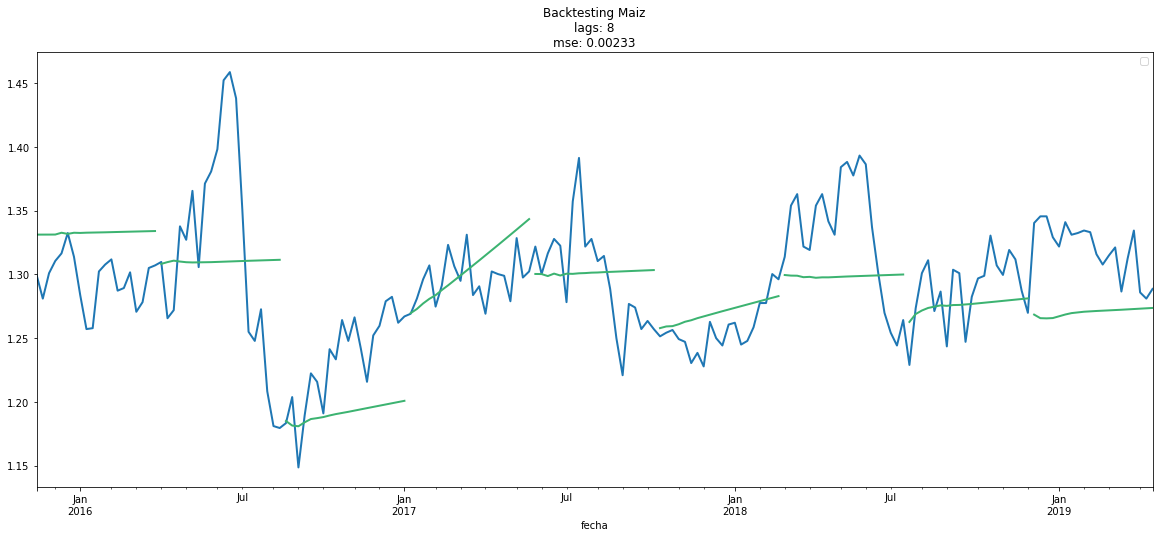

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Graficar backtesting y calcular métrica

fig, ax = plt.subplots()
y[backtesting_series.index].plot(ax=ax)
(backtesting_series).plot(ax=ax, c='C1')
mse = mean_squared_error(y[backtesting_series.index], backtesting_series.mean(1))
plt.title(f'Backtesting {grano.capitalize()}\nlags: {lags}\nmse: {round(mse, 5)}')
plt.legend([])

In [13]:
# Histogramas de tasas de crecimiento predecidas por ambos modelos
# pd.concat([backtesting_series1.mean(1),
#            backtesting_series2.mean(1)], axis=1).plot.kde()

In [14]:
# GridSearch
# ==============================================================================
from skforecast.model_selection import grid_search_forecaster

lags_grid = [4, 8, 16, 20]

# param_grid_nn = dict(hidden_layer_sizes=[(100,), (100, 100), (200,)],
#                      alpha=[0.001, 0.0001, 0.00001])

results_grid = grid_search_forecaster(
                                    forecaster = forecaster,
                                    y          = pd.Series(scaler.fit_transform(train.to_frame())[:, 0]),
                                    param_grid = {},
                                    lags_grid  = lags_grid,
                                    initial_train_size = int(len(train_back)*0.8),
                                    fixed_train_size   = False,
                                    steps      = steps,
                                    metric     = 'mean_squared_error',
                                    refit      = True,
                                    verbose    = False,
                                    )
results_grid

Number of models compared: 4


loop lags_grid: 100%|███████████████████████████████████████| 4/4 [00:11<00:00,  2.85s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7 8] 
  Parameters: {}
  Backtesting metric: 0.003442977045466289



,lags,params,metric
1,"[1, 2, 3, 4, 5, 6, 7, 8]",{},0.003443
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},0.003528
0,"[1, 2, 3, 4]",{},0.003929
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},0.004082


In [15]:
# Backtesting enlatado
# from skforecast.model_selection import backtesting_forecaster

# metric, predictions_backtest = backtesting_forecaster(
#                                     forecaster = forecaster,
#                                     y          = pd.Series(scaler.fit_transform(train.to_frame())[:, 0], index=train.index),
#                                     initial_train_size = int(len(train_back)*0.7),
#                                     fixed_train_size   = False,
#                                     steps      = steps,
#                                     metric     = 'mean_squared_error',
#                                     refit      = True,
#                                     verbose    = False
#                                     )

# print(f"Backtest error: {metric}")

# predictions_backtest = pd.Series(scaler.inverse_transform(predictions_backtest)[:, 0], index=train[-len(predictions_backtest):].index)

# fig, ax = plt.subplots()
# train.iloc[-len(predictions_backtest):].plot(ax=ax, label='test')
# predictions_backtest.plot(ax=ax, label='predictions')
# ax.legend();